In [2]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import numpy as np
import pandas as pd

from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import preprocessing

from statsmodels.tsa.stattools import coint

from scipy import stats

from quantopian.pipeline.data import morningstar
from quantopian.pipeline.filters.morningstar import Q500US, Q1500US, Q3000US
from quantopian.pipeline import Pipeline
from quantopian.research import run_pipeline

9/6/17 Changed below date from "2017-06-01" to "2017-09-01"

In [3]:
study_date = "2017-09-01"

Let's define our universe

Note:
The orignial notebook used the Q1500 universe so if you encounter any issues it might help to try that one again.

In [4]:
universe = Q3000US()

NOTE: The hashed out code shown below is the code from the original notebook.

Avoid making any changes to it in case we need it later.

In [14]:
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest
    },
    screen=universe
    )

In [1]:
'''
pipe = Pipeline(
    columns= {
        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),
        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,
        'Financial Health': morningstar.asset_classification.financial_health_grade.latest,
        'EBITDA Margin': morningstar.operation_ratios.ebitda_margin.latest
    },
    screen=universe
    )
'''

"\npipe = Pipeline(\n    columns= {\n        'Market Cap': morningstar.valuation.market_cap.latest.quantiles(5),\n        'Industry': morningstar.asset_classification.morningstar_industry_group_code.latest,\n        'Financial Health': morningstar.asset_classification.financial_health_grade.latest,\n        'EBITDA Margin': morningstar.operation_ratios.ebitda_margin.latest\n    },\n    screen=universe\n    )\n"

In [15]:
res = run_pipeline(pipe, study_date, study_date)
res.index = res.index.droplevel(0) # Let's drop the single date from the multi-index

In [16]:
print res.shape
res.head()

(2271, 3)


,Financial Health,Industry,Market Cap
Equity(2 [ARNC]),C,31061,4
Equity(24 [AAPL]),A,31167,4
Equity(31 [ABAX]),A,20640,2
Equity(41 [ARCB]),C,31062,2
Equity(52 [ABM]),B,31054,3


In [17]:
# Remove stocks with the industry classification of "Conglomerates"
res = res[res['Industry']!=31055]
print res.shape

(2261, 3)


In [18]:
# Remove stocks without a Financial Health grade
res = res[res['Financial Health']!= None]
print res.shape

(2254, 3)


In [19]:
# Replace the categorical data with numerical scores per the docs
res['Financial Health'] = res['Financial Health'].astype('object')
health_dict = {u'A': 0.1,
              u'B': 0.3,
              u'C': 0.7,
              u'D': 0.9,
              u'F': 1.0}
res = res.replace({'Financial Health': health_dict})

In [20]:
res.describe()

,Financial Health,Industry,Market Cap
count,2254.000000,2254.000000,2254.000000
mean,0.477684,19746.625998,2.978705
std,0.268420,9237.814473,0.796402
min,0.100000,10101.000000,2.000000
25%,0.300000,10320.000000,2.000000
50%,0.300000,20635.000000,3.000000
75%,0.700000,31054.000000,4.000000
max,1.000000,31169.000000,4.000000


Define Daily Return Horizon

For this strategy we're going to work with a daily return horizon

The original DateOffset value was 24 but since we recently had quite the impactful presidential election, I'm going to change this value to 12 so as to create more significance around more recent market changes.

In [21]:
pricing = get_pricing(
    symbols=res.index,
    fields='close_price',
    start_date=pd.Timestamp(study_date) - pd.DateOffset(months=12),
    end_date=pd.Timestamp(study_date)
)

In [22]:
pricing.shape

(253, 2254)

In [23]:
returns = pricing.pct_change()

In [24]:
type(returns)

<class 'pandas.core.frame.DataFrame'>

In [25]:
returns.head()

,Equity(2 [ARNC]),Equity(24 [AAPL]),Equity(31 [ABAX]),Equity(41 [ARCB]),Equity(52 [ABM]),Equity(53 [ABMD]),Equity(62 [ABT]),Equity(67 [ADSK]),Equity(76 [TAP]),Equity(110 [ACXM]),...,Equity(50716 [DXC]),Equity(50718 [PUMP]),Equity(50735 [AYX]),Equity(50749 [BTU]),Equity(50763 [SNDR]),Equity(50780 [HCC]),Equity(50781 [YEXT]),Equity(50782 [UPL]),Equity(50910 [JHG]),Equity(51040 [BBX])
2016-09-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-02 00:00:00+00:00,-0.001000,0.009421,-0.017841,0.013011,0.006705,-0.001360,-0.004725,0.009650,0.017084,0.006862,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-06 00:00:00+00:00,0.019777,-0.000283,-0.001226,-0.002168,0.001306,0.004427,0.002021,-0.004705,0.023122,-0.005869,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-07 00:00:00+00:00,-0.011643,0.006321,-0.004849,0.020366,-0.007956,0.009069,-0.006536,0.013444,-0.006382,0.005142,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-09-08 00:00:00+00:00,-0.007842,-0.026488,0.003043,0.026772,0.045516,0.007224,-0.001663,0.003061,-0.015947,-0.010421,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


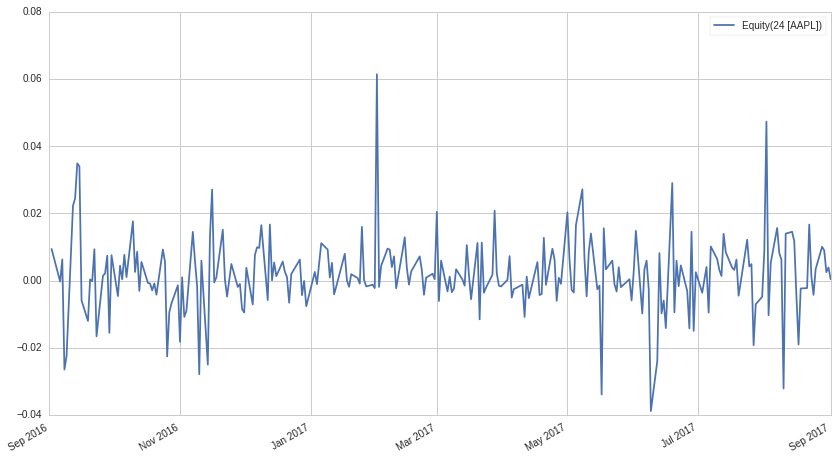

In [26]:
returns[symbols(['AAPL'])].plot();

In [27]:
# We can only work with stocks that have the full return series
# so we need to drop any that have NaN values from our returns DataFrame
returns = returns.iloc[1:,:].dropna(axis=1)

In [28]:
print returns.shape

(252, 2194)


Now, let's find candidate pairs for pairs trading models

PCA Decomposition and DBSCAN Clustering

In [29]:
N_PRIN_COMPONENTS = 50
pca = PCA(n_components=N_PRIN_COMPONENTS)
pca.fit(returns)

PCA(copy=True, n_components=50, whiten=False)

In [30]:
pca.components_.T.shape

(2194, 50)

Note that we've now reduced the data with the N_PRIN_COMPONENTS principal component loadings. 

Adding some fundamental values will make the model more robust so we'll do that next.

In [31]:
X = np.hstack(
    (pca.components_.T,
    res['Market Cap'][returns.columns].values[:, np.newaxis],
    res['Financial Health'][returns.columns].values[:, np.newaxis])
)

print X.shape

(2194, 52)


Including the two cells below to illustrate the change that is made to the structure of the data. From rows to columns. 

In [32]:
print res['Market Cap'][returns.columns].values

[4 4 2 ..., 2 3 2]


In [33]:
print res['Market Cap'][returns.columns].values[:, np.newaxis]

[[4]
 [4]
 [2]
 ..., 
 [2]
 [3]
 [2]]


In [34]:
X = preprocessing.StandardScaler().fit_transform(X)
print X.shape

(2194, 52)


In [35]:
clf = DBSCAN(eps=1.9, min_samples=3)
print clf

clf.fit(X)
labels = clf.labels_
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
print "\nClusters discovered: %d" % n_clusters_

clustered = clf.labels_

DBSCAN(algorithm='auto', eps=1.9, leaf_size=30, metric='euclidean',
    min_samples=3, p=None, random_state=None)

Clusters discovered: 7


In [37]:
# Here is the initial dimensionality of the search
ticker_count = len(returns.columns)
print "Total pairs possible in universe: %d " % (ticker_count*(ticker_count-1)/2)

Total pairs possible in universe: 2405721 


In [38]:
clustered_series = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series_all = pd.Series(index=returns.columns, data=clustered.flatten())
clustered_series = clustered_series[clustered_series != -1]

In [39]:
CLUSTER_SIZE_LIMIT = 9999
counts = clustered_series.value_counts()
ticker_count_reduced = counts[(counts>1) & (counts<=CLUSTER_SIZE_LIMIT)]
print "Clusters formed: %d" % len(ticker_count_reduced)
print "Pairs evaluated: %d" % (ticker_count_reduced*(ticker_count_reduced-1)).sum()

Clusters formed: 7
Pairs evaluated: 988


Clustering reduced the search space for pairs from >1mm to approximately 2,000.


Cluster Visualization

T-SNE is an algorithm that allows us to visualize high dimension data in 2d. We want to visualize the discovered pairs to help us gain confidence that the DBSCAN output makes sense. We also want to make sure that T-SNE and DBSCAN both find our clusters.

In [40]:
X_tsne = TSNE(learning_rate=1000, perplexity=25, random_state=1337).fit_transform(X)

In [41]:
# TSNE returns a numpy array, X_tsne which contains 2 dimensions.
# Now we can graph it on the x and y axis of a scatter plot.
print X_tsne.shape

(2194, 2)


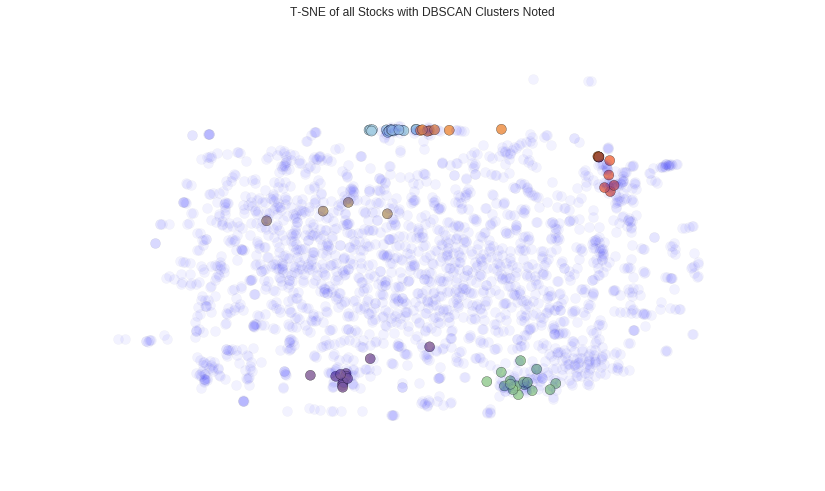

In [42]:
plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')

# First let's create a scatter plot for our X_tsne labels from our clusters.
# We'll assign different color codes to each cluster and within our chosen color palette
# and we'll assign similar colors to members that belong to the same cluster.
plt.scatter(
    X_tsne[(labels!=-1), 0], # This is x
    X_tsne[(labels!=-1), 1], # This is y
    s=100,
    alpha=0.85,
    c=labels[labels!=-1],
    cmap=cm.Paired
)

# Now let's plot every other stock from our universe so we can compare.
# No need for color codes here because they aren't part of any of our clusters.
plt.scatter(
    X_tsne[(clustered_series_all==-1).values, 0], # This is x
    X_tsne[(clustered_series_all==-1).values, 1], # This is y
    s=100,
    alpha=0.05
)

plt.title('T-SNE of all Stocks with DBSCAN Clusters Noted');

Let's visualize how many stocks we found in each cluster and then we'll visualize the normalized time series of the members of some of the smaller clusters

In [43]:
print clustered_series.value_counts()

0    21
1    19
5    12
4     7
6     5
3     5
2     4
dtype: int64


In [44]:
print len(clustered_series.value_counts())

7


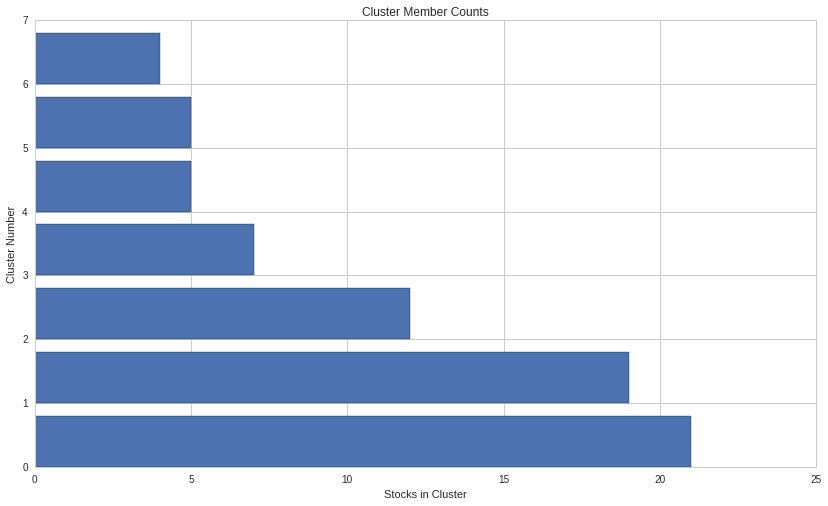

In [45]:
plt.barh(
    xrange(len(clustered_series.value_counts())), # Vary x-axis length w/ number of stocks in our largest cluster.
    clustered_series.value_counts() # This is the y-axis. Plots the number of stocks in each cluster.
)
plt.title('Cluster Member Counts')
plt.xlabel('Stocks in Cluster')
plt.ylabel('Cluster Number')

To again visualize if our clustering is doing anything sensible, let's look at a few clusters (for reproducibility, keep all random state and dates the same in this notebook).

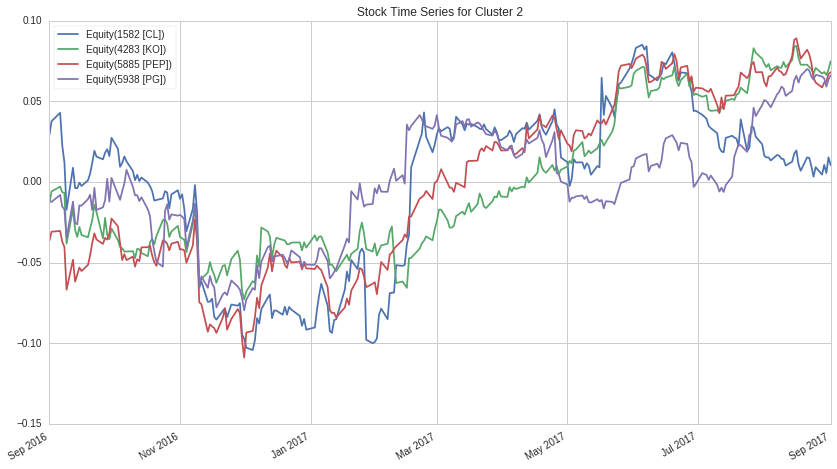

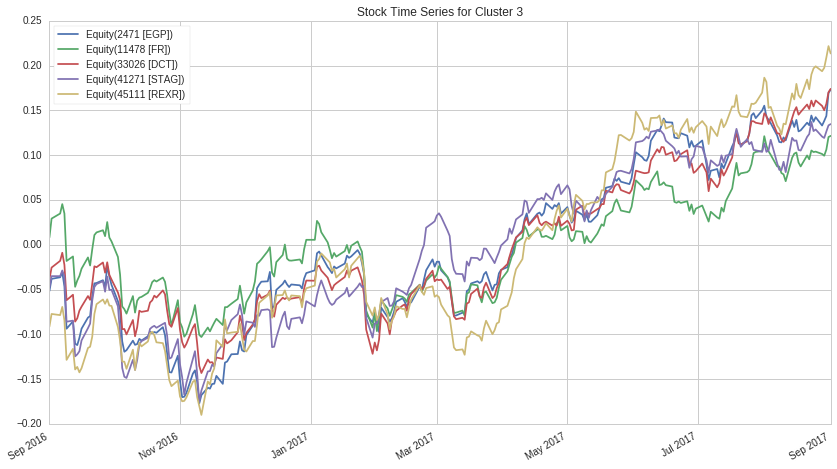

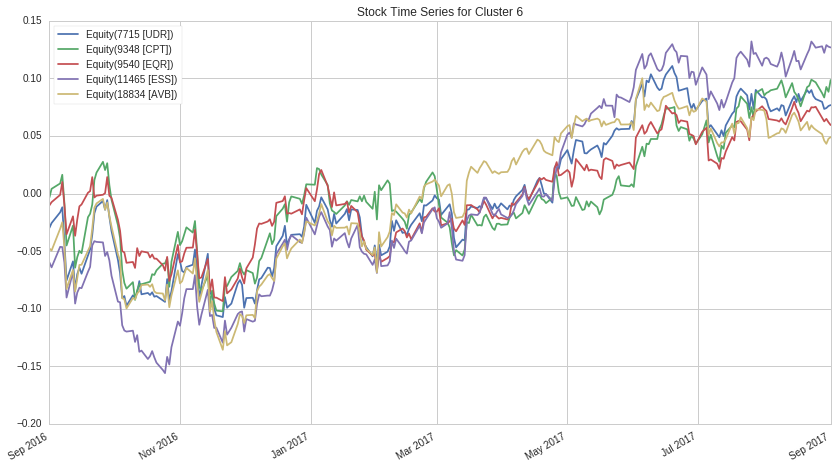

In [46]:
# Get the number of stocks in each cluster
counts = clustered_series.value_counts()

# Let's visualize some clusters
cluster_vis_list = list(counts[(counts<20) & (counts>1)].index)[::-1]

# Plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 3)]:
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

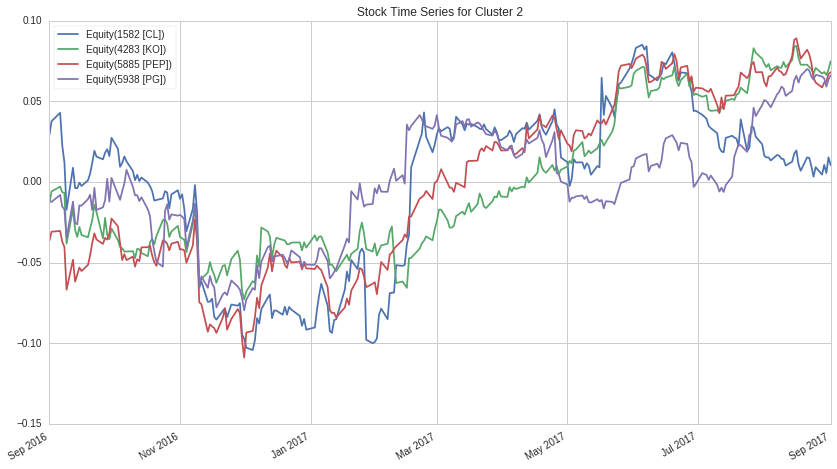

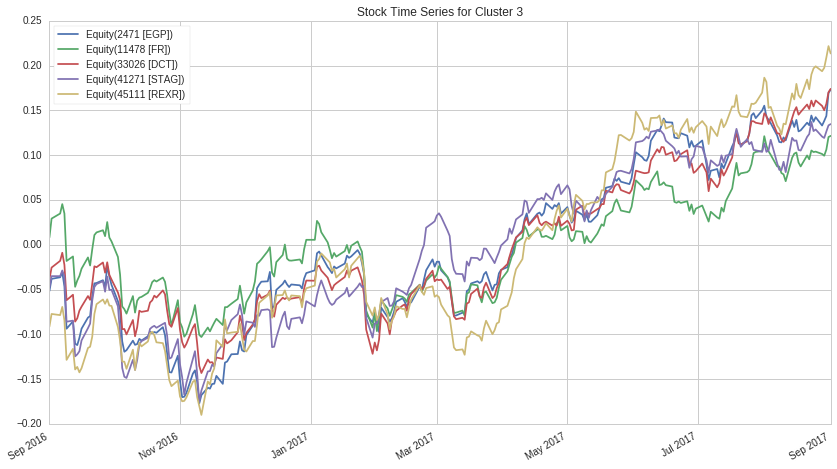

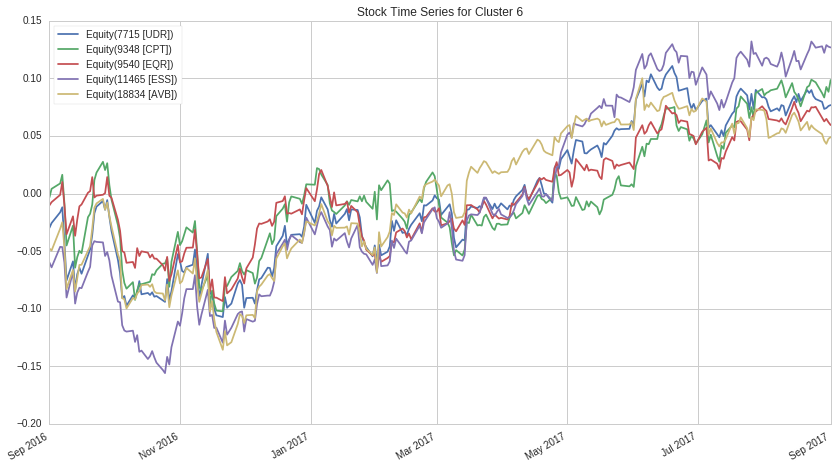

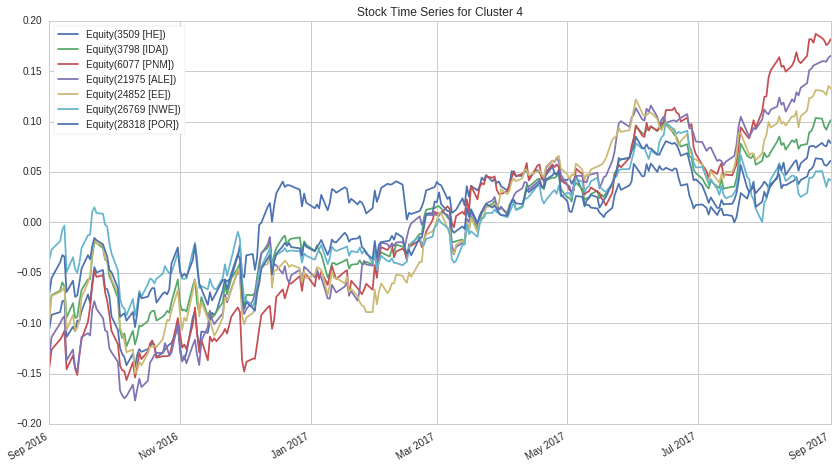

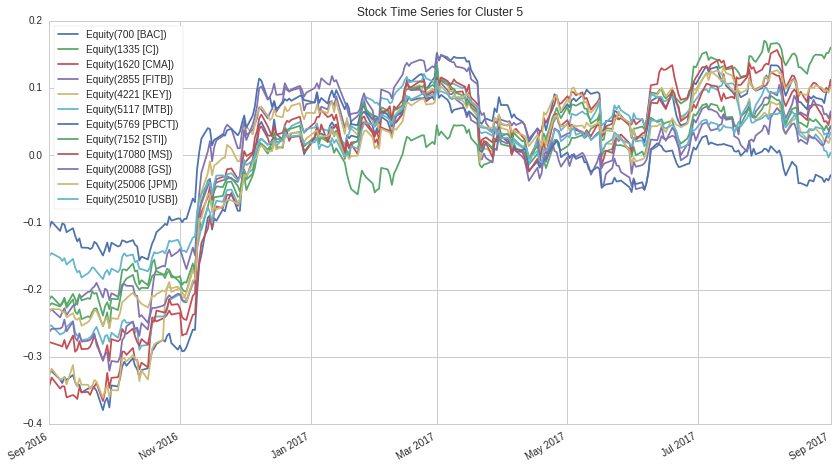

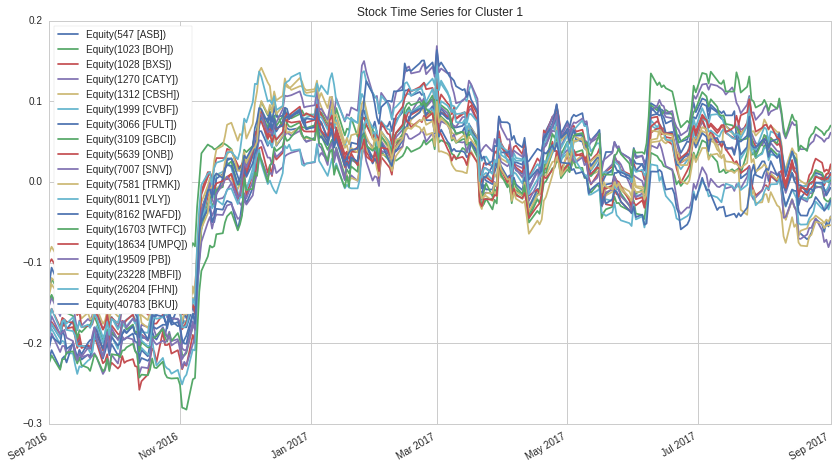

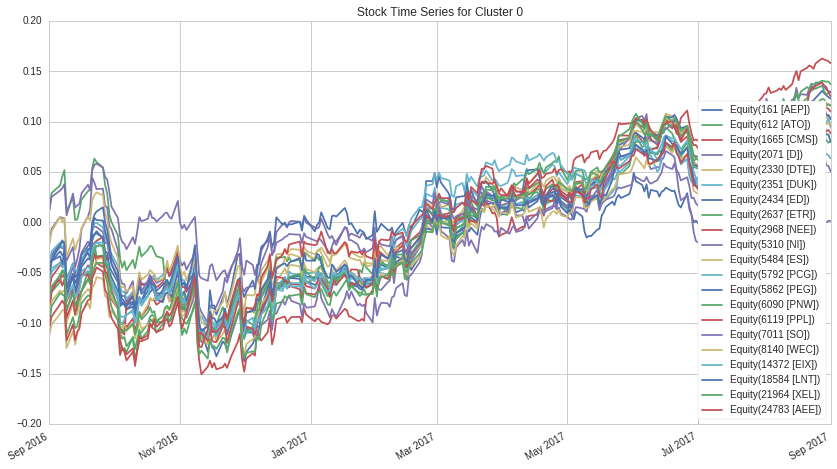

In [47]:
# Get the number of stocks in each cluster
counts = clustered_series.value_counts()

# Let's visualize some clusters
cluster_vis_list = list(counts[(counts<100) & (counts>1)].index)[::-1]

# Plot a handful of the smallest clusters
for clust in cluster_vis_list[0:min(len(cluster_vis_list), 10)]: # Chose 10 here to b/c that was the num. of clusters found and I wanted them all graphed.
    tickers = list(clustered_series[clustered_series==clust].index)
    means = np.log(pricing[tickers].mean())
    data = np.log(pricing[tickers]).sub(means)
    data.plot(title='Stock Time Series for Cluster %d' % clust)

Let's see how a cluster looks for a particular stock.

In [48]:
which_cluster = clustered_series.loc[symbols('AEP')]
clustered_series[clustered_series == which_cluster]

Equity(161 [AEP])      0
Equity(612 [ATO])      0
Equity(1665 [CMS])     0
Equity(2071 [D])       0
Equity(2330 [DTE])     0
Equity(2351 [DUK])     0
Equity(2434 [ED])      0
Equity(2637 [ETR])     0
Equity(2968 [NEE])     0
Equity(5310 [NI])      0
Equity(5484 [ES])      0
Equity(5792 [PCG])     0
Equity(5862 [PEG])     0
Equity(6090 [PNW])     0
Equity(6119 [PPL])     0
Equity(7011 [SO])      0
Equity(8140 [WEC])     0
Equity(14372 [EIX])    0
Equity(18584 [LNT])    0
Equity(21964 [XEL])    0
Equity(24783 [AEE])    0
dtype: int64

In [49]:
which_cluster = clustered_series.loc[symbols('JPM')]
clustered_series[clustered_series == which_cluster]

Equity(700 [BAC])      5
Equity(1335 [C])       5
Equity(1620 [CMA])     5
Equity(2855 [FITB])    5
Equity(4221 [KEY])     5
Equity(5117 [MTB])     5
Equity(5769 [PBCT])    5
Equity(7152 [STI])     5
Equity(17080 [MS])     5
Equity(20088 [GS])     5
Equity(25006 [JPM])    5
Equity(25010 [USB])    5
dtype: int64

In [50]:
which_cluster = clustered_series.loc[symbols('ASB')]
clustered_series[clustered_series == which_cluster]

Equity(547 [ASB])       1
Equity(1023 [BOH])      1
Equity(1028 [BXS])      1
Equity(1270 [CATY])     1
Equity(1312 [CBSH])     1
Equity(1999 [CVBF])     1
Equity(3066 [FULT])     1
Equity(3109 [GBCI])     1
Equity(5639 [ONB])      1
Equity(7007 [SNV])      1
Equity(7581 [TRMK])     1
Equity(8011 [VLY])      1
Equity(8162 [WAFD])     1
Equity(16703 [WTFC])    1
Equity(18634 [UMPQ])    1
Equity(19509 [PB])      1
Equity(23228 [MBFI])    1
Equity(26204 [FHN])     1
Equity(40783 [BKU])     1
dtype: int64

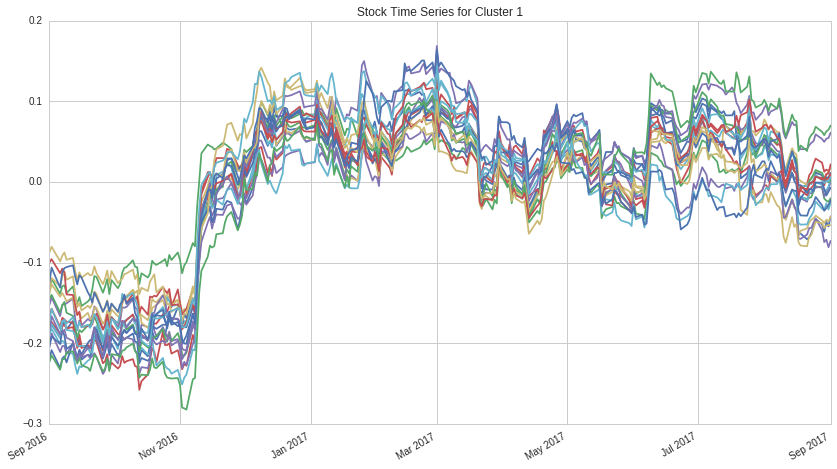

In [51]:
tickers = list(clustered_series[clustered_series==which_cluster].index)
means = np.log(pricing[tickers].mean())
data = np.log(pricing[tickers]).sub(means)
data.plot(legend=False, title="Stock Time Series for Cluster %d" % which_cluster);

We can now validate the cointegration relationships because we have sensible clusters of common stocks

In [52]:
def find_cointegrated_pairs(data, significance=0.05):
    # This function is from https://www.quantopian.com/lectures/introduction-to-pairs-trading
    n = data.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = data[keys[i]]
            S2 = data[keys[j]]
            result = coint(S1, S2)
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < significance:
                pairs.append((keys[i], keys[j]))
    return score_matrix, pvalue_matrix, pairs

In [53]:
cluster_dict = {}
for i, which_clust in enumerate(ticker_count_reduced.index):
    tickers = clustered_series[clustered_series == which_clust].index
    score_matrix, pvalue_matrix, pairs = find_cointegrated_pairs(
        pricing[tickers]
    )
    cluster_dict[which_clust] = {}
    cluster_dict[which_clust]['score_matrix'] = score_matrix
    cluster_dict[which_clust]['pvalue_matrix'] = pvalue_matrix
    cluster_dict[which_clust]['pairs'] = pairs

In [54]:
pairs = []
for clust in cluster_dict.keys():
    pairs.extend(cluster_dict[clust]['pairs'])

In [55]:
pairs

[(Equity(161 [AEP]), Equity(1665 [CMS])),
 (Equity(161 [AEP]), Equity(2351 [DUK])),
 (Equity(161 [AEP]), Equity(2434 [ED])),
 (Equity(161 [AEP]), Equity(18584 [LNT])),
 (Equity(612 [ATO]), Equity(1665 [CMS])),
 (Equity(612 [ATO]), Equity(2434 [ED])),
 (Equity(612 [ATO]), Equity(6090 [PNW])),
 (Equity(612 [ATO]), Equity(18584 [LNT])),
 (Equity(612 [ATO]), Equity(21964 [XEL])),
 (Equity(1665 [CMS]), Equity(2351 [DUK])),
 (Equity(1665 [CMS]), Equity(5484 [ES])),
 (Equity(1665 [CMS]), Equity(6090 [PNW])),
 (Equity(1665 [CMS]), Equity(18584 [LNT])),
 (Equity(1665 [CMS]), Equity(21964 [XEL])),
 (Equity(2071 [D]), Equity(2330 [DTE])),
 (Equity(2071 [D]), Equity(6119 [PPL])),
 (Equity(2351 [DUK]), Equity(2434 [ED])),
 (Equity(2351 [DUK]), Equity(2968 [NEE])),
 (Equity(2351 [DUK]), Equity(18584 [LNT])),
 (Equity(2351 [DUK]), Equity(21964 [XEL])),
 (Equity(2434 [ED]), Equity(18584 [LNT])),
 (Equity(2434 [ED]), Equity(21964 [XEL])),
 (Equity(2968 [NEE]), Equity(5310 [NI])),
 (Equity(5310 [NI]), E

In [56]:
print "We found %d pairs." % len(pairs)

We found 47 pairs.


In [57]:
print "In those pairs, there are %d unqiue tickers." % len(np.unique(pairs))

In those pairs, there are 36 unqiue tickers.


For those pairs that we found and validated, let's visualize them in 2d space with T-SNE

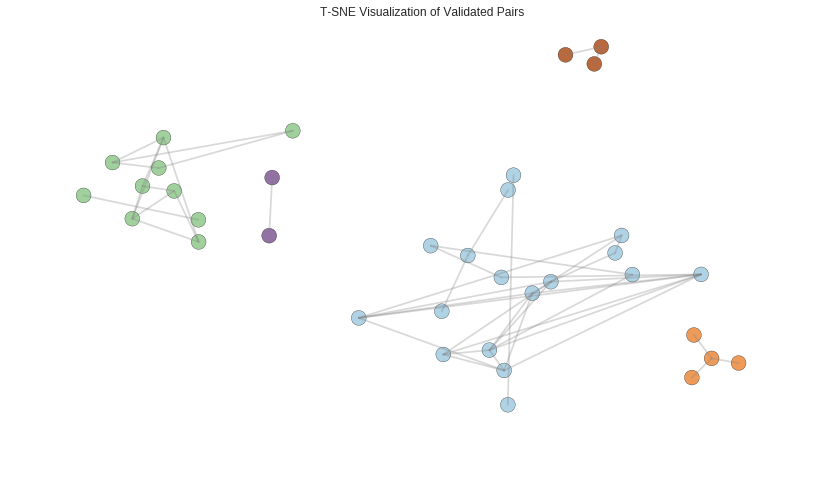

In [58]:
stocks = np.unique(pairs)
X_df = pd.DataFrame(index=returns.T.index, data=X)
in_pairs_series = clustered_series.loc[stocks]
stocks = list(np.unique(pairs))
X_pairs = X_df.loc[stocks]

X_tsne = TSNE(learning_rate=50, perplexity=3, random_state=1337).fit_transform(X_pairs)

plt.figure(1, facecolor='white')
plt.clf()
plt.axis('off')
for pair in pairs:
    ticker1 = pair[0].symbol
    loc1 = X_pairs.index.get_loc(pair[0])
    x1, y1 = X_tsne[loc1, :]
    
    ticker2 = pair[0].symbol
    loc2 = X_pairs.index.get_loc(pair[1])
    x2, y2 = X_tsne[loc2, :]
    
    plt.plot([x1, x2], [y1, y2], 'k-', alpha=0.3, c='gray');

plt.scatter(X_tsne[:, 0], X_tsne[:, 1], s=220, alpha=0.9, c=[in_pairs_series.values], cmap=cm.Paired)
plt.title('T-SNE Visualization of Validated Pairs');